In [30]:
%matplotlib inline

# Importing libraries

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy

In [32]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression as LR_SK
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.ensemble import RandomForestRegressor,forest

**Granting replicability**

In [33]:
import random as rn
import os

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)

In [34]:
path = "/Users/eulerr/Documents/Mestrado Unicamp/Machine Learning/Assignment-01/"

In [35]:
!pwd

/Users/eulerr/Documents/Mestrado Unicamp/Machine Learning/Assignment-01


# Helping Functions

In [158]:
class LinearRegression():
    def __init__(self, n_in, n_out):
        self.weight = np.random.uniform(-0.1,0.1,(n_out,n_in)) #initializing parameters

    def forward(self, x_bias):
        return x_bias.dot(self.weight.T)
    
    def fit(self,xtrain,ytrain,xval,yval,
                epochs,learning_rate,
                alpha,patience,verbose=0):
        
        pt = copy.copy(patience)
        
        hist ={'loss':[],'val_loss':[],'bestloss':1e100,'best_weights':self.weight}

        n_samples = xtrain.shape[0]

        for epoch in range(epochs):

            
            # forward - predict
            out = self.forward(xtrain)

            #loss function 
            loss = mse(out,ytrain)

            # gradient by partial derivatives
            weight_grad = (2.0/n_samples) * (xtrain.T).dot(xtrain.dot(self.weight.T) - ytrain) + 2*alpha*self.weight.T


            # updating weights by gradient descendent
            self.weight = self.weight - learning_rate * weight_grad.T 


            # Predicting validation set 
            out_val = self.forward(xval)

            #loss on validation set
            loss_val = mse(out_val,yval)


            # Saving history : 
            if patience==0: print(f'Patience 0 in epoch {epoch}');break

            hist['loss'].append(loss)
            hist['val_loss'].append(loss_val)    

            if loss_val < hist['bestloss']: 
                hist['bestloss']= loss_val
                hist['best_weights']= self.weight
                patience = pt

            # EarlyStop

            if loss_val >= hist['bestloss']: patience -=1;


            # verbose
            if verbose>0:
                print(f'\nEpoch[{epoch+1}/{epochs}], loss: {loss}   val_loss: {loss_val}')

        return hist




In [37]:
def R2_adjusted(y,yhat,p):
    
    SS_Residual = np.sum(np.square(y-yhat))
    SS_Total = np.sum(np.square(y - np.mean(y) ))
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adjusted_r_squared = 1 - (1-r_squared)*(y.shape[0]-1)/(y.shape[0] - p -1)
    return adjusted_r_squared

In [229]:
def cross_validate(nat_weights, x, y,lr=65e-3,l2=1e-5, folds=5):
    '''
    Function to do the cross validation.
    nat_weights = Weights of linear regression as initial state before training.
    x = training data, numpy array
    y = training labels, numpy array
    folds = K, the number of folds to divide the data into
    '''
    score = np.zeros(folds)
    hist = [{}]*folds
    kf = KFold(n_splits=folds,random_state=32) 
    i=0
    model = LinearRegression(x.shape[1],1)   
    model.weight = nat_weights # Put the weights on a predefined state
    
    for train_ind,test_ind in kf.split(x):
        print(f'Fold {i+1} out of {folds}')
        xtrain,ytrain = x[train_ind,:],y[train_ind]
        xtest,ytest = x[test_ind,:],y[test_ind]
        
        model.weight = nat_weights # Put the weights on a predefined state
        
        hist [i] = model.fit(xtrain,ytrain,xtest,ytest,
                             epochs=3000,learning_rate=lr,alpha=l2,
                             patience=10,verbose=0)

        ypred = model.forward(xtest)
        score[i] = mse(ypred,ytest)
        i+=1
        
        
    print(f'\nOverall MSE: {score}')
    print(f'Mean:{score.mean()}')
    print(f'StD:{score.std()}')
    return hist

In [39]:
def mse(x,y):
    return np.square(x-y).mean()

def rmse(x,y):
    return np.sqrt(np.square(x-y).mean())

# Importing dataset

In [40]:
datatrain = pd.read_csv(f'{path}train.csv')
datatrain.head(2)

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/04/18/may-fourth-be-w...,630.0,12.0,363.0,0.571823,1.0,0.773585,5.0,3.0,1.0,...,0.033333,1.0,-0.250000,-0.4,-0.15,0.571429,0.357143,0.071429,0.357143,5100
1,http://mashable.com/2014/05/23/edgar-wright-sh...,230.0,11.0,502.0,0.591919,1.0,0.777778,6.0,1.0,2.0,...,0.100000,0.8,-0.304167,-0.7,-0.05,0.000000,0.000000,0.500000,0.000000,3100


In [41]:
datatrain.duplicated(keep=False).sum(),datatrain.isnull().sum().sum()

(0, 0)

In [42]:
datatest = pd.read_csv(f'{path}test.csv')
test_target = pd.read_csv(f'{path}test_target.csv')

In [43]:
datatest['shares'] = test_target.shares.values

In [44]:
del test_target

In [45]:
datatest.duplicated(keep=False).sum(),datatest.isnull().sum().sum()

(0, 0)

In [46]:
predictors = [x for x in datatrain.columns if x not in ['shares','url','timedelta']]
Target= 'shares'

In [47]:
pred_n = [x for x in predictors if x.startswith('n_')]; pred_n.append('average_token_length');
pred_num = [x for x in predictors if x.startswith('num_')]
pred_data = [x for x in predictors if x.startswith('data_')]
pred_kw = [x for x in predictors if x.startswith('kw_')]
pred_self = [x for x in predictors if x.startswith('self_')]
pred_weekday = [x for x in predictors if x.startswith('weekday_')];pred_weekday.append('is_weekend');
pred_LDA = [x for x in predictors if x.startswith('LDA_')]
pred_global = [x for x in predictors if x.startswith('global_')]
pred_rate = [x for x in predictors if x.startswith('rate_')]
pred_pol = ['avg_positive_polarity', 'min_positive_polarity',
            'max_positive_polarity', 'avg_negative_polarity',
            'min_negative_polarity', 'max_negative_polarity', 
            'title_subjectivity','title_sentiment_polarity',
            'abs_title_subjectivity','abs_title_sentiment_polarity',]

In [48]:
datatrain.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

In [49]:
preds = [pred_n, pred_num, pred_data, pred_kw, pred_self,
         pred_weekday, pred_LDA, pred_global, pred_rate, pred_pol]

In [50]:
len(pred_n+ pred_num+pred_data+pred_kw+pred_self+
    pred_weekday + pred_LDA + pred_global+pred_rate+pred_pol ),len(predictors)


(58, 58)

# Feature Scaling

In [51]:
len(predictors)

58

In [358]:
#scaler = StandardScaler()
scaler = MinMaxScaler()


In [359]:
scaled_tr =  scaler.fit_transform(datatrain[predictors])
scaled_test =  scaler.transform(datatest[predictors].values)

# Target Scaling and Analysis

In [56]:
#test_scaler = StandardScaler()
test_scaler = MinMaxScaler()
#test_scaler = RobustScaler()



In [57]:
datatrain[Target].describe()

count     31715.000000
mean       3364.264386
std       10742.884480
min           1.000000
25%         945.000000
50%        1400.000000
75%        2800.000000
max      690400.000000
Name: shares, dtype: float64

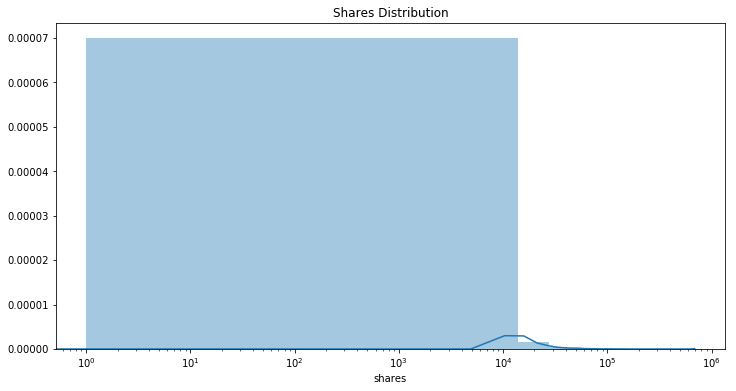

In [58]:
plt.figure(figsize=(12,6))
sns.distplot(datatrain[Target],hist=True,kde=True)
plt.xscale('log')
plt.title("Shares Distribution")
plt.show()

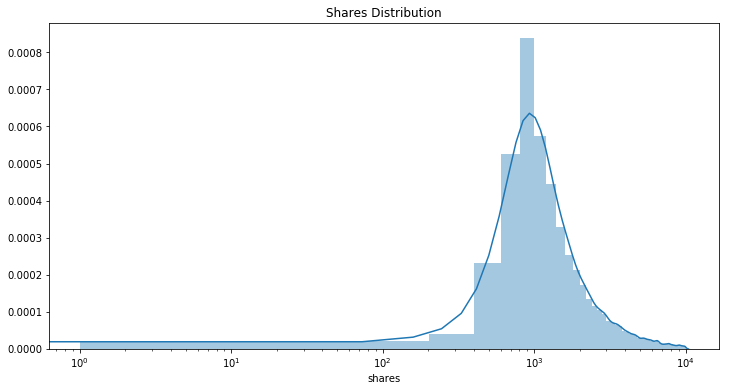

In [59]:
plt.figure(figsize=(12,6))
sns.distplot(datatrain[(datatrain[Target]<=1e4)][Target],hist=True,kde=True)
plt.xscale('log')
plt.title("Shares Distribution")
plt.show()

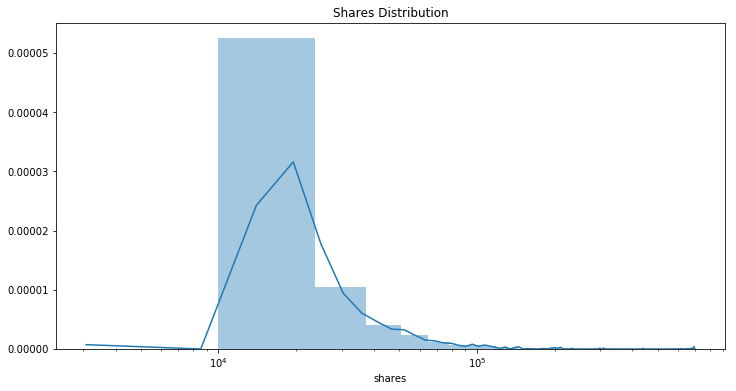

In [60]:
plt.figure(figsize=(12,6))
sns.distplot(datatrain[(datatrain[Target]>=1e4)][Target],hist=True,kde=True)
plt.xscale('log')
plt.title("Shares Distribution")
plt.show()

# Linear Regression 

In [367]:
xval= scaled_test.copy()
xtrain = scaled_tr.copy()
xtrain.shape,xval.shape

((31715, 58), (7929, 58))

In [361]:
ytrain = test_scaler.fit_transform(datatrain[Target].values.reshape(-1,1))
yval =  test_scaler.transform(datatest[Target].values.reshape(-1,1))

ytrain.shape,yval.shape

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


((31715, 1), (7929, 1))

$$ \mathbf{\hat{y}} = \mathbf{x} \mathbf{w^T} $$

In [244]:
LR = LinearRegression(len(predictors),1)

In [245]:
# Testing a predict

LR.forward(xtrain).shape

(31715, 1)

In [168]:
# Natural state of weights for strategies comparison

nat_weights = LR.weight
nat_weights.shape

(1, 58)

## Training the model 

Loss function (MSE) with L2 regularization :
$$ J(\hat{y_i},y_i) = \frac{1}{M} \sum_{i=0}^{M-1} (\hat{y_i} - y_i)^2 +  \lambda\sum_{i=0}^{k}w_{i}^2$$

Gradient:
    $$  \mathbf{\nabla{J_w}} = \frac{2}{M}\mathbf{x^T}(\mathbf{x w^T} -\mathbf{y}) +2\lambda w^T $$

Updating parameters via gradient descent with weight decay ( L2 Regularization ):
    $$ \mathbf{w} = \mathbf{w} −\eta (\mathbf{\nabla J_w}^T)$$

In [248]:
LR.weight = nat_weights # Restoring natural state

hist= LR.fit(xtrain,ytrain,xval,yval,
             epochs=1500,learning_rate=1e-1,alpha=1e-5,
             patience=10,verbose = 0)

In [249]:
hist["bestloss"],np.sqrt(hist["bestloss"])

(0.00047210244919674351, 0.021727918657725675)

Comparing with sklearning Linear Regression

In [250]:
lr = LR_SK()
lr.fit(xtrain,ytrain)
ypred = lr.predict(xval)
mse(yval,ypred),rmse(yval,ypred)

(0.00048080157220002211, 0.021927187968365257)

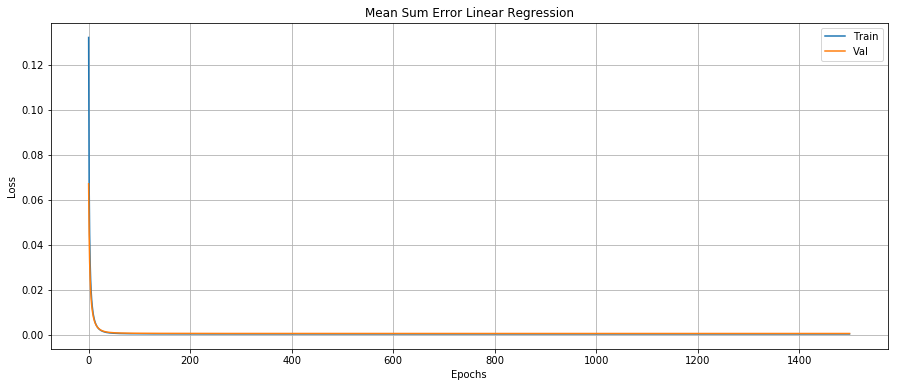

In [225]:
fig = plt.figure(figsize=(15,6))
plt.plot(hist["loss"],label="Train") # mostrando log para amplificar valores baixos
plt.plot(hist["val_loss"],label="Val")
#plt.ylim(0.6,1.2) # escala máximo y no gráfico 
plt.title('Mean Sum Error Linear Regression')
plt.ylabel("Loss")
#plt.semilogx()
#plt.semilogy()
plt.xlabel("Epochs")
plt.legend()
plt.grid(True)

plt.show()

In [230]:
hist = cross_validate(nat_weights,xtrain,ytrain,lr=1e-1,l2=1e-6)

Fold 1 out of 5
Fold 2 out of 5
Fold 3 out of 5
Patience 0 in epoch 688
Fold 4 out of 5
Fold 5 out of 5

Overall MSE: [ 0.00047666  0.00018821  0.0003617   0.04514132  0.00010292]
Mean:0.009254163494235362
StD:0.017944051116652312


## Feature Selection

best training loss : 0.021727918657725675

In [252]:
losses = []

for pred in preds: 
    n_predictors = list(set(predictors) - set(pred))

    xtrain = scaler.fit_transform(datatrain[n_predictors].values)
    xval= scaler.transform(datatest[n_predictors].values)
    
    LR = LinearRegression(len(n_predictors),1)
    
    hist= LR.fit(xtrain,ytrain,xval,yval,
             epochs=2000,learning_rate=1e-1,alpha=1e-5,
             patience=10,verbose = 0)
    losses.append(np.sqrt(hist["bestloss"])) # RMSE
losses    

[0.021455122313068377,
 0.021427690601613789,
 0.021871967042433889,
 0.02142732876498343,
 0.021640047193601131,
 0.021673931597540125,
 0.02181757949355044,
 0.021405971851674248,
 0.021297890717915938,
 0.021322201234091395]

In [254]:
n_predictors = list(set(predictors) - set(preds[1])- set(preds[3])- set(preds[8])- set(preds[9]))

In [255]:
xtrain = scaler.fit_transform(datatrain[n_predictors].values)
xval= scaler.transform(datatest[n_predictors].values)

LR = LinearRegression(len(n_predictors),1)

hist= LR.fit(xtrain,ytrain,xval,yval,
         epochs=2000,learning_rate=1e-1,alpha=1e-5,
         patience=10,verbose = 0)

np.sqrt(hist["bestloss"])

0.021276062819534126

In [259]:
len(n_predictors),len(preds)

(32, 10, (1, 32))

In [258]:
(best_loss/0.021727918657725675)*100

97.920390602940316

In [260]:
npreds = [preds[0], preds[2], preds[4] , preds[5] , preds[6] , preds[7]]
len(npreds)

6

In [262]:
losses = []

for pred in npreds: 
    tmp_pr = list(set(n_predictors) - set(pred))

    xtrain = scaler.fit_transform(datatrain[tmp_pr].values)
    xval= scaler.transform(datatest[tmp_pr].values)
    
    LR = LinearRegression(len(tmp_pr),1)
    
    hist= LR.fit(xtrain,ytrain,xval,yval,
             epochs=2000,learning_rate=1e-1,alpha=1e-5,
             patience=10,verbose = 0)
    losses.append(np.sqrt(hist["bestloss"]))
losses    

[0.021261102750286313,
 0.021124846970331693,
 0.021250356272246168,
 0.021242905624663883,
 0.021398659971757182,
 0.021119670784485612]

In [264]:
npreds[-1]

['global_subjectivity',
 'global_sentiment_polarity',
 'global_rate_positive_words',
 'global_rate_negative_words']

In [266]:
n1_predictors = list(set(n_predictors) - set(npreds[0])- set(preds[2])- set(preds[3])- set(preds[4])- set(preds[5]))

In [307]:
xtrain = scaler.fit_transform(datatrain[n1_predictors].values)
xval= scaler.transform(datatest[n1_predictors].values)

LR = LinearRegression(len(n1_predictors),1)

hist= LR.fit(xtrain,ytrain,xval,yval,
         epochs=5000,learning_rate=1e-1,alpha=1e-5,
         patience=10,verbose = 0)

np.sqrt(hist["bestloss"])

0.021133670726454567

In [308]:
(np.sqrt(hist["bestloss"])/0.021727918657725675)*100

97.265048987746397

In [309]:
(hist["bestloss"]/0.00047210244919674351)*100,hist["bestloss"]

(94.60489754588707, 0.00044663203837420272)

In [310]:
len(predictors),len(n1_predictors)

(58, 9)

In [284]:
n1_predictors

['LDA_03',
 'global_sentiment_polarity',
 'LDA_02',
 'LDA_04',
 'global_rate_positive_words',
 'global_rate_negative_words',
 'LDA_00',
 'LDA_01',
 'global_subjectivity']

In [312]:
best_loss = hist["bestloss"];best_weights = hist["best_weights"]
best_weights.shape

(1, 9)

## Non linear transformations 

In [285]:
predictors_sqr = [x +'2' for x in n1_predictors]
predictors_cub = [x +'3' for x in n1_predictors]

In [286]:
datatrain[predictors_sqr] = np.square(datatrain[n1_predictors])
datatrain[predictors_cub] = np.power(datatrain[n1_predictors],3)

In [288]:
datatest[predictors_sqr] = np.square(datatest[n1_predictors])
datatest[predictors_cub] = np.power(datatest[n1_predictors],3)

In [318]:
non_lin_pred = n1_predictors + predictors_sqr + predictors_cub
len(non_lin_pred)

27

In [319]:
xtrain = scaler.fit_transform(datatrain[non_lin_pred].values)
xval= scaler.transform(datatest[non_lin_pred].values)

LR = LinearRegression(len(non_lin_pred),1)

hist= LR.fit(xtrain,ytrain,xval,yval,
         epochs=3000,learning_rate=1e-1,alpha=1e-5,
         patience=10,verbose = 0)

np.sqrt(hist["bestloss"]),hist["bestloss"]

(0.021363056094707226, 0.00045638016570560759)

In [320]:
np.sqrt(best_loss) < np.sqrt(hist["bestloss"])

True

No improvement found

In [327]:
non_lin_pred = n1_predictors + predictors_cub 
len(non_lin_pred)

18

In [329]:
xtrain = scaler.fit_transform(datatrain[non_lin_pred].values)
xval= scaler.transform(datatest[non_lin_pred].values)

LR = LinearRegression(len(non_lin_pred),1)

hist= LR.fit(xtrain,ytrain,xval,yval,
         epochs=3000,learning_rate=1e-1,alpha=1e-5,
         patience=10,verbose = 0)

np.sqrt(hist["bestloss"]),hist["bestloss"]

(0.021235837568414673, 0.00045096079723209206)

In [330]:
best_loss < np.sqrt(hist["bestloss"])

True

No improvement found

## Separating popular and unpopular articles 

In [313]:
datatrain[Target].describe()

count     31715.000000
mean       3364.264386
std       10742.884480
min           1.000000
25%         945.000000
50%        1400.000000
75%        2800.000000
max      690400.000000
Name: shares, dtype: float64

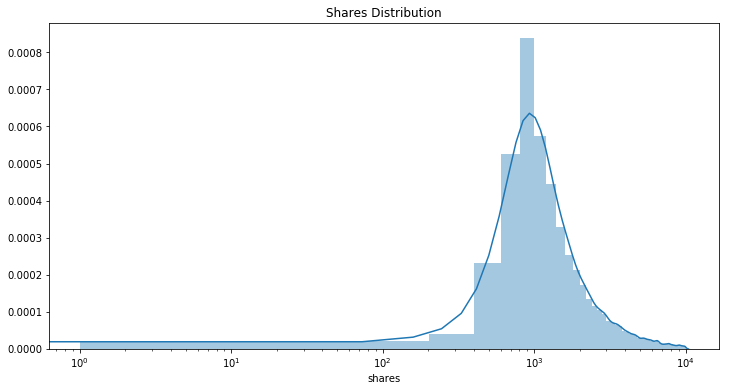

In [334]:
plt.figure(figsize=(12,6))
sns.distplot(datatrain[(datatrain[Target]<=1e4)][Target],hist=True,kde=True)
plt.xscale('log')
plt.title("Shares Distribution")
plt.show()

In [314]:
len(n1_predictors),len(predictors)

(9, 58)

In [347]:
xtrain = scaler.fit_transform(datatrain[(datatrain[Target]<=1e4)][n1_predictors].values)
xval= scaler.transform(datatest[(datatest[Target]<=1e4)][n1_predictors].values)

xtrain.shape,xval.shape

((29984, 9), (7475, 9))

In [348]:
ytrain = test_scaler.fit_transform(datatrain[(datatrain[Target]<=1e4)][Target].values.reshape(-1,1))
yval =  test_scaler.transform(datatest[(datatest[Target]<=1e4)][Target].values.reshape(-1,1))

ytrain.shape,yval.shape

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


((29984, 1), (7475, 1))

In [350]:
LR = LinearRegression(len(n1_predictors),1)

#LR.weight = best_weights

hist= LR.fit(xtrain,ytrain,xval,yval,
         epochs=3000,learning_rate=1e-1,alpha=1e-5,
         patience=10,verbose = 0)

np.sqrt(hist["bestloss"]),hist["bestloss"]

(0.17209362866866496, 0.029616217028348338)

## Evaluating model

In [353]:
xtrain = scaler.fit_transform(datatrain[n1_predictors].values)
xval= scaler.transform(datatest[n1_predictors].values)

LR = LinearRegression(len(n_predictors),1)

In [354]:
# Loading best epoch weights

LR.weight = best_weights

# Testing result 
y_pred = LR.forward(xval)

mse(y_pred,yval),rmse(y_pred,yval)

(0.00044663203837420272, 0.021133670726454567)

In [355]:
y_pred.min(),y_pred.max(),y_pred.std()

(0.00081438545608793385, 0.010525015593795293, 0.0015715333567741544)

In [356]:
yval.min(),yval.max(),yval.std()

(5.7937511496974936e-06, 1.2214661376971865, 0.021202047076748616)

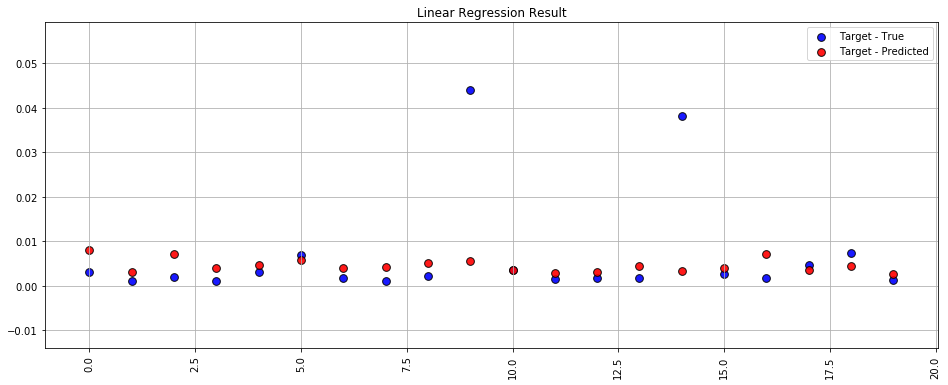

In [357]:
n_samples = 20

fig = plt.figure(figsize=(16,6))     

X= np.arange(0, y_pred.shape[0],1).reshape(-1,1)


plt.scatter(X[:n_samples,:],yval[:n_samples,:], c = 'blue',
            edgecolors='black',s = 60,alpha = 0.9,linewidths=1, 
            marker = "o", label='Target - True')

plt.scatter(X[:n_samples,:],y_pred[:n_samples,:], c = 'red', 
            edgecolors='black',s = 60,alpha = 0.9,linewidths=1, 
            marker = "o", label='Target - Predicted')


plt.xticks(rotation=90)
plt.title('Linear Regression Result')
plt.xlabel('')
plt.ylabel('')
#plt.ylim([-25e-6,25e-6])
plt.grid('on')
plt.legend()
plt.show()